# Q-Learning
 Applying the Q-learning algorithm using Numpy and OpenAI Gym.
 
 [Reference](https://github.com/simoninithomas/Deep_reinforcement_learning_Course/blob/master/Q%20learning/FrozenLake/Q%20Learning%20with%20FrozenLake.ipynb)

## Environment - CartPole-v1

This is a classic control problem implemented in the Gym package. From the docs: 

>A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

An example of the final control achieved is shown below.

![CartPole Gif](https://github.com/Fernandohf/Reinforcement-Learning/blob/master/gym/results/result.gif?raw=true)

Complete [list of environments](https://gym.openai.com/envs/#classic_control).

Import relevant packages:
- **Gym**: Load environment.
- **Numpy**: Efficient matricial operations.
- **Seaborn**: Visualization.

In [1]:
import gym
import numpy as np
import seaborn as sns

Create the environment and get the states bounds.

In [2]:
# Create GYM environment
env = gym.make("CartPole-v1")

In [3]:
# Observation bounds
obs_low = env.observation_space.low
obs_high = env.observation_space.high
print(f"Min state values: {obs_low}")
print(f"Max state values: {obs_high}")

Min state values: [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
Max state values: [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]


In [4]:
# Bins to digitize position, angle, and angular velocity
res1 = 50
res2 = 50
res3 = 20
bins = [np.linspace(obs_low[0], obs_high[0], res1),
        np.linspace(obs_low[2], obs_high[2], res2),
        np.linspace(-10, 10, res3),]

In [5]:
# This function discretize the states variables
def get_dstates(states, bins):
    """
    Discretize only 3 state variables.
    """
    d_states = []
    c_states = [states[0], states[2], states[3]]
    for i, s in enumerate(c_states):
        d_states.append(np.digitize(s, bins[i]))
    return tuple(d_states)

These states are 4 variables related to the cart:

Index| State Variable
:---:|:---
0 |Cart Position
1 |Cart Velocity
2 |Pole Angle
3 |Pole Velocity (at tip)

In order to apply Q-Learning algorithm, we will discretize those variable. In order to train faster, we will ignore the **Cart Velocity** state.

In [6]:
# Number of actions and states
action_size = env.action_space.n
print(action_size)

2


The environment allows 2 possible discrete actions:

Index| Action Variable
:---:|:---
0 |Push Cart Left
1 |Push Cart Right


Here, we create the q-table with the dimensions corresponding to each state variable discretization bucket and actions. Additionally, the hyperparameters are selected:

- *Episodes*: Total number of episodes to fill q-table.
- *Learning Rate*: Learning rate used in Bellman's Equation.
- *Max Steps*: Max number of steps in each episode.
- *Gamma*: Discounting rate for old rewards.
- *Epsilon*: Initial Epsilon value, close to 1 represents exploration.
- *Decay Rate*: Rate to reduce Epsilon value.


In [7]:
# Initialize q-table
qtable = np.zeros((res1 + 1, res2 + 1, res3 + 1, action_size))

print(qtable.shape)
# Hyperparameters
total_episodes = 10000      # Total episodes
learning_rate = 0.2         # Learning rate
max_steps = 200             # Max steps per episode
gamma = 0.95                # Discounting rate

# Exploration parameters
epsilon = 1.0               # Exploration rate
max_epsilon = 1.0           # Exploration probability at start
min_epsilon = 0.1          # Minimum exploration probability 
decay_rate = 0.001         # Exponential decay rate for exploration prob

(51, 51, 21, 2)


### Q-Table
Now that everything is ready, the Q-table can start to be filled with values.

In [8]:
# List of rewards
rewards = []

# 2 For life or until learning is stopped
for episode in range(total_episodes):
    # Reset the environment
    states = env.reset()
    dstates = get_dstates(states, bins)
    step = 0
    done = False
    total_rewards = 0
    
    for step in range(max_steps):
        # 3. Choose an action a in the current world state (s)
        ## First we randomize a number
        exp_exp_tradeoff = np.random.uniform(0, 1)
        
        ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
        if exp_exp_tradeoff > epsilon:
            action = np.argmax(qtable[dstates])

        # Else doing a random choice --> exploration
        else:
            action = env.action_space.sample()

        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, done, info = env.step(action)
        new_dstates = get_dstates(new_state, bins)
        # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
        # qtable[new_state,:] : all the actions we can take from new state
        ind = dstates + (action,)
        qtable[ind] = (qtable[ind] + 
                       learning_rate * (reward + gamma * np.max(qtable[new_dstates]) -
                                        qtable[ind]))
        
        total_rewards += reward
        
        # Our new state is state
        state = new_state
        dstates = new_dstates
        # If done (if we're dead) : finish episode
        if done == True: 
            break
        
    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode) 
    rewards.append(total_rewards)

print ("Score over time: " +  str(sum(rewards)/total_episodes))

Score over time: 143.2519


## Results

Using the highest reward for each state on **Q-Table**, we can estimate the best action. The code below executes the simulation following the optimal actions trained.

In [9]:
# Show final results
# Wrapper to save  as video
menv = gym.wrappers.Monitor(env, "results", force=True) # Uncomment to save video
for episode in range(3):
    states = menv.reset()
    dstates = get_dstates(states, bins)
    step = 0
    done = False
    print("****************************************************")
    print("EPISODE ", episode)
    for step in range(250):
        
        # Take the action (index) that have the maximum expected future reward given that state
        action = np.argmax(qtable[dstates])
        
        new_state, reward, done, info = menv.step(action)
        new_dstates = get_dstates(new_state, bins)
        ind = dstates + (action,)
        menv.render()
        if done:
            # Here, we decide to only print the last state (to see if our agent is on the goal or fall into an hole)
            # We print the number of step it took.
            print("Number of steps", step)
            break
        state = new_state
        dstates = new_dstates
    else:
        menv.close()
menv.close()

****************************************************
EPISODE  0
****************************************************
EPISODE  1
****************************************************
EPISODE  2
Number of steps 187


## Reward Evolution

The graph shows how the mean reward evolves during the Q-Table filling phase.

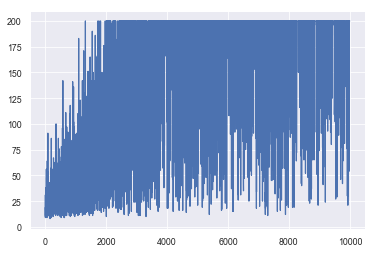

In [10]:
# Rewards
sns.lineplot(range(len(rewards)), rewards)

## Epsilon Decay

How the epsilon value decays with the number of epsiodes.

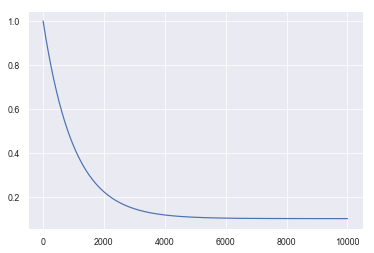

In [11]:
# Rewards
x = np.arange(1, total_episodes)
y = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*x) 
sns.lineplot(x, y)